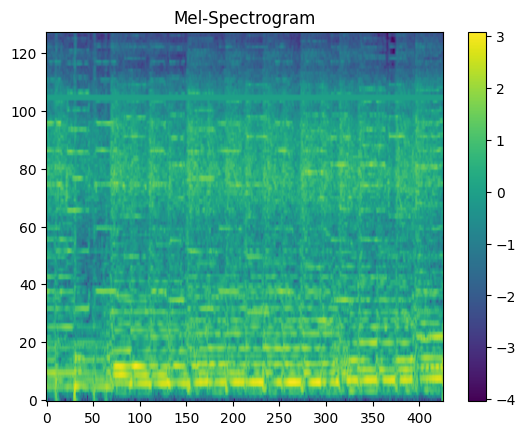

In [1]:
import torch
import torchaudio
import torchaudio.transforms as T
import numpy as np
from torch.utils.data import Dataset, DataLoader
import os

class AudioDataset(Dataset):
    def __init__(self, file_list, sample_rate=16000, n_fft=1024, hop_length=256, n_mels=128, augment=False):
        """
        Audio dataset for loading and preprocessing audio files into Mel-spectrograms.
        
        Args:
            file_list (list): List of file paths to audio files.
            sample_rate (int): Target sample rate for resampling.
            n_fft (int): FFT size for the STFT.
            hop_length (int): Hop length for the STFT.
            n_mels (int): Number of Mel filter banks.
            augment (bool): Whether to apply data augmentation.
        """
        self.file_list = file_list
        self.sample_rate = sample_rate
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.n_mels = n_mels
        self.augment = augment

        # Mel-spectrogram transform
        self.mel_transform = T.MelSpectrogram(
            sample_rate=self.sample_rate,
            n_fft=self.n_fft,
            hop_length=self.hop_length,
            n_mels=self.n_mels
        )

        # Normalization transform
        self.amplitude_to_db = T.AmplitudeToDB(stype="power", top_db=80)

        # Augmentation (optional)
        self.time_masking = T.TimeMasking(time_mask_param=20)
        self.freq_masking = T.FrequencyMasking(freq_mask_param=10)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        # Load audio file
        file_path = self.file_list[idx]
        waveform, sr = torchaudio.load(file_path)

        # Resample if necessary
        if sr != self.sample_rate:
            resampler = T.Resample(orig_freq=sr, new_freq=self.sample_rate)
            waveform = resampler(waveform)

        # Convert to mono
        if waveform.shape[0] > 1:
            waveform = waveform.mean(dim=0, keepdim=True)

        # Apply Mel-spectrogram transform
        mel_spectrogram = self.mel_transform(waveform)

        # Convert amplitude to decibels
        mel_spectrogram = self.amplitude_to_db(mel_spectrogram)

        # Normalize across the dataset (optional: apply min-max normalization)
        mel_spectrogram = (mel_spectrogram - mel_spectrogram.mean()) / (mel_spectrogram.std() + 1e-6)

        # Apply augmentations if enabled
        if self.augment:
            mel_spectrogram = self.time_masking(mel_spectrogram)
            mel_spectrogram = self.freq_masking(mel_spectrogram)

        return mel_spectrogram

# Helper function to create dataset and dataloader
def create_dataloader(folder_path, batch_size=16, augment=False):
    """
    Create a DataLoader for the dataset.

    Args:
        folder_path (str): Path to the folder containing audio files.
        batch_size (int): Batch size for DataLoader.
        augment (bool): Whether to apply data augmentation.

    Returns:
        DataLoader: DataLoader for the audio dataset.
    """
    # Get all .wav files in the folder
    file_list = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.wav')]
    dataset = AudioDataset(file_list, augment=augment)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

# Example usage
if __name__ == "__main__":
    folder_path = "ground_truth_others"
    batch_size = 16

    # Create DataLoader
    dataloader = create_dataloader(folder_path, batch_size=batch_size, augment=True)

    # Visualize a sample
    import matplotlib.pyplot as plt
    for mel_spectrogram in dataloader:
        # Show the first spectrogram in the batch
        plt.imshow(mel_spectrogram[0].squeeze(0).numpy(), aspect="auto", origin="lower", cmap="viridis")
        plt.title("Mel-Spectrogram")
        plt.colorbar()
        plt.show()
        break
